In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c feedback-prize-effectiveness

 61% 5.00M/8.13M [00:00<00:00, 12.1MB/s]
100% 8.13M/8.13M [00:00<00:00, 19.3MB/s]


In [ ]:
! unzip feedback-prize-effectiveness.zip

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
dataset_tr = pd.read_csv('/content/train.csv')
dataset_tr.head(5)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [ ]:
dataset_test = pd.read_csv('/content/test.csv')
dataset_test.head(5)

,discourse_id,essay_id,discourse_text,discourse_type
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. ...,Lead
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim


### EDA

In [ ]:
dataset_tr.nunique()

discourse_id               36765
essay_id                    4191
discourse_text             36691
discourse_type                 7
discourse_effectiveness        3
dtype: int64

In [ ]:
dataset_tr.isna().sum()

discourse_id               0
essay_id                   0
discourse_text             0
discourse_type             0
discourse_effectiveness    0
dtype: int64

In [ ]:
dataset_tr['discourse_type'].unique()

array(['Lead', 'Position', 'Claim', 'Evidence', 'Counterclaim',
       'Rebuttal', 'Concluding Statement'], dtype=object)

In [ ]:
dataset_tr['discourse_effectiveness'].unique()

array(['Adequate', 'Ineffective', 'Effective'], dtype=object)

In [ ]:
def proportions_pie(data, col, title):
    counts = data[col].value_counts()
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', radius=2)
    plt.axis('equal')
    plt.title(title)
    plt.show()

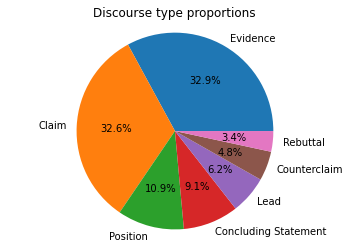

In [ ]:
proportions_pie(dataset_tr, 'discourse_type', 'Discourse type proportions')

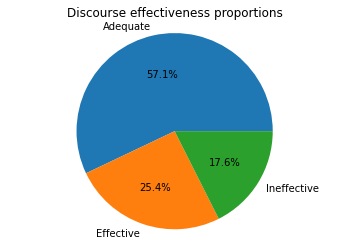

In [ ]:
proportions_pie(dataset_tr, 'discourse_effectiveness', 'Discourse effectiveness proportions')

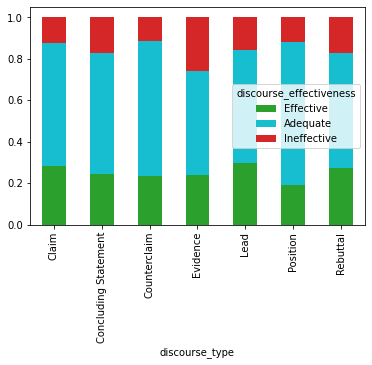

In [ ]:
counts = dataset_tr.groupby(by='discourse_type')["discourse_effectiveness"].value_counts(normalize=True).unstack(fill_value=0)
counts[['Effective', 'Adequate', 'Ineffective']].plot.bar(stacked=True, color=['tab:green', 'tab:cyan', 'tab:red'])
plt.show()

In [ ]:
corpus = dataset_tr['discourse_text'].values
labels = dataset_tr['discourse_effectiveness'].values

text_test = dataset_test['discourse_text'].values

In [ ]:
target_map = {"Ineffective":0, "Adequate":1,"Effective":2}
dataset_tr["target"] = dataset_tr["discourse_effectiveness"].map(target_map)

In [ ]:
len(corpus)

36765

In [ ]:
len(text_test)

10

### Preprocess

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
def preprocess(text):
  corpus = []
  for i in range(0, len(text)):
    review = re.sub('[^a-zA-Z]', ' ', text[i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    all_stopwords = stopwords.words('english')
    #all_stopwords.remove('not')
    review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
    review = ' '.join(review)
    corpus.append(review)
  return corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
corpus= preprocess(corpus)
test_corpus= preprocess(text_test)

In [ ]:
targets = dataset_tr['target'].values
x_train, x_val, y_train, y_val = train_test_split(corpus, targets, test_size=0.2, random_state=42)

In [ ]:
#removing terms that appear too infrequently # 70% with 5 #1 consider all words.
#x_v = vectorizer.transform(targets)

vectorizer = TfidfVectorizer(min_df=1)
x_t = vectorizer.fit_transform(x_train)
x_v = vectorizer.transform(x_val)
x_test = vectorizer.transform(test_corpus)

#### Logestic

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500, class_weight=None) 

In [ ]:
model.fit(x_t, y_train.ravel())

LogisticRegression(max_iter=500)

In [ ]:
train_pred = model.predict(x_t)
val_pred = model.predict(x_v)
test_pred = model.predict(x_test)

In [ ]:
#probability
train_proba = model.predict_proba(x_t)
val_proba = model.predict_proba(x_v)
test_proba = model.predict_proba(x_test)

In [ ]:
#Train Metrics:
from sklearn.metrics import log_loss
print('Train Metrics:')
print('F1: ' + str(sklearn.metrics.f1_score(y_train, train_pred, average='micro')))
print('Accuracy: ' + str(sklearn.metrics.accuracy_score(y_train, train_pred)))
print('Log Loss: ' + str(log_loss(y_train, train_proba)))

Train Metrics:
F1: 0.7063443492452061
Accuracy: 0.7063443492452061
Log Loss: 0.6849086418523122


In [ ]:
# Validation Metrics
print('Validation Metrics:')
print('F1: ' + str(sklearn.metrics.f1_score(y_val, val_pred, average='micro')))
print('Accuracy: ' + str(sklearn.metrics.accuracy_score(y_val, val_pred)))
print('Log Loss: ' + str(log_loss(y_val, val_proba)))

Validation Metrics:
F1: 0.6440908472732219
Accuracy: 0.6440908472732219
Log Loss: 0.7859759155695579


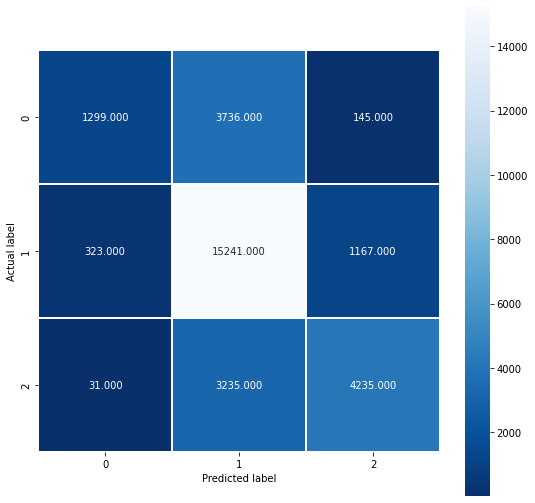

In [ ]:
cm = sklearn.metrics.confusion_matrix(y_train, train_pred)
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier_ = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

In [ ]:
classifier_.fit(x_t, y_train.ravel())

KNeighborsClassifier()

In [ ]:
train_pred2 = classifier_.predict(x_t)
val_pred2 = classifier_.predict(x_v)
test_pred2 = classifier_.predict(x_test)

In [ ]:
#probability
train_proba2 = classifier_.predict_proba(x_t)
val_proba2 = classifier_.predict_proba(x_v)
test_proba2 = classifier_.predict_proba(x_test)

In [ ]:
#Train Metrics:
from sklearn.metrics import log_loss
print('Train Metrics:')
print('F1: ' + str(sklearn.metrics.f1_score(y_train, train_pred2, average='micro')))
print('Accuracy: ' + str(sklearn.metrics.accuracy_score(y_train, train_pred2)))
print('Log Loss: ' + str(log_loss(y_train, train_proba2)))

Train Metrics:
F1: 0.6367129062967496
Accuracy: 0.6367129062967496
Log Loss: 0.7019261361725802


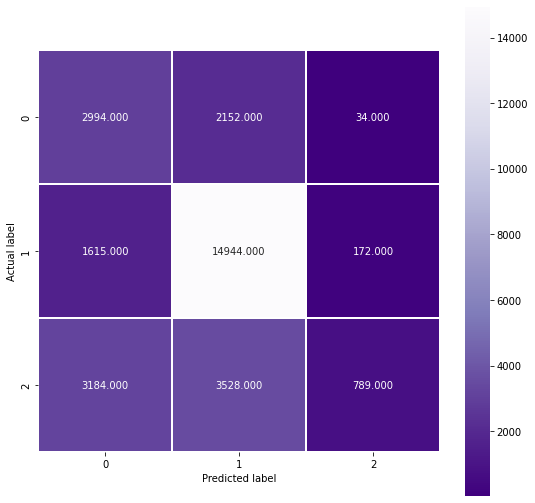

In [ ]:
cm = sklearn.metrics.confusion_matrix(y_train, train_pred2)
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Purples_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
# Validation Metrics
print('Validation Metrics:')
print('F1: ' + str(sklearn.metrics.f1_score(y_val, val_pred2, average='micro')))
print('Accuracy: ' + str(sklearn.metrics.accuracy_score(y_val, val_pred2)))
print('Log Loss: ' + str(log_loss(y_val, val_proba2)))

Validation Metrics:
F1: 0.5157078743370053
Accuracy: 0.5157078743370053
Log Loss: 7.153931436618928


#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfClas= RandomForestClassifier(max_depth=2, n_estimators=30, min_samples_split=3, max_leaf_nodes=5, random_state=22)

In [ ]:
rfClas.fit(x_t, y_train.ravel())

RandomForestClassifier(max_depth=2, max_leaf_nodes=5, min_samples_split=3,
                       n_estimators=30, random_state=22)

In [ ]:
train_pred4 = rfClas.predict(x_t)
val_pred4 = rfClas.predict(x_v)
test_pred4 = rfClas.predict(x_test)

In [ ]:
#probability
train_proba4 = rfClas.predict_proba(x_t)
val_proba4 = rfClas.predict_proba(x_v)
test_proba4 = rfClas.predict_proba(x_test)

In [ ]:
#Train Metrics:
from sklearn.metrics import log_loss
print('Train Metrics:')
print('F1: ' + str(sklearn.metrics.f1_score(y_train, train_pred4, average='micro')))
print('Accuracy: ' + str(sklearn.metrics.accuracy_score(y_train, train_pred4)))
print('Log Loss: ' + str(log_loss(y_train, train_proba4)))

Train Metrics:
F1: 0.5688494492044064
Accuracy: 0.5688494492044064
Log Loss: 0.9614785884033331


In [ ]:
# Validation Metrics
print('Validation Metrics:')
print('F1: ' + str(sklearn.metrics.f1_score(y_val, val_pred4, average='micro')))
print('Accuracy: ' + str(sklearn.metrics.accuracy_score(y_val, val_pred4)))
print('Log Loss: ' + str(log_loss(y_val, val_proba4)))

Validation Metrics:
F1: 0.5774513803889569
Accuracy: 0.5774513803889569
Log Loss: 0.9548513439439946


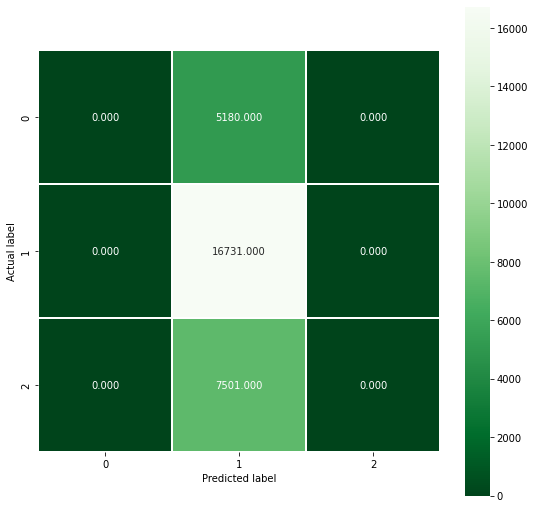

In [ ]:
cm = sklearn.metrics.confusion_matrix(y_train, train_pred4)
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Greens_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

#### XG Boost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_t, y_train.ravel())

XGBClassifier(objective='multi:softprob')

In [ ]:
train_pred5 = xgb_clf.predict(x_t)
val_pred5 = xgb_clf.predict(x_v)
test_pred5 = xgb_clf.predict(x_test)

In [ ]:
#probability
train_proba5 = xgb_clf.predict_proba(x_t)
val_proba5 = xgb_clf.predict_proba(x_v)
test_proba5 = xgb_clf.predict_proba(x_test)

In [ ]:
#Train Metrics:
from sklearn.metrics import log_loss
print('Train Metrics:')
print('F1: ' + str(sklearn.metrics.f1_score(y_train, train_pred5, average='micro')))
print('Accuracy: ' + str(sklearn.metrics.accuracy_score(y_train, train_pred5)))
print('Log Loss: ' + str(log_loss(y_train, train_proba5)))

Train Metrics:
F1: 0.6475928192574459
Accuracy: 0.6475928192574459
Log Loss: 0.8264113506866503


In [ ]:
# Validation Metrics
print('Validation Metrics:')
print('F1: ' + str(sklearn.metrics.f1_score(y_val, val_pred5, average='micro')))
print('Accuracy: ' + str(sklearn.metrics.accuracy_score(y_val, val_pred5)))
print('Log Loss: ' + str(log_loss(y_val, val_proba5)))

Validation Metrics:
F1: 0.6349789201686387
Accuracy: 0.6349789201686387
Log Loss: 0.8479386217986911


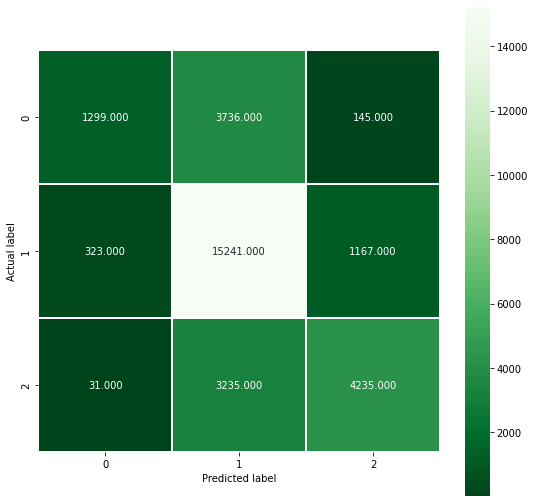

In [ ]:
cm = sklearn.metrics.confusion_matrix(y_train, train_pred)
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Greens_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
#logestic
submission = pd.DataFrame(columns=['discourse_id', 'Ineffective', 'Adequate', 'Effective'])

for i, row in dataset_test.iterrows():
    p = test_proba[i, :]
    submission.loc[i] = [row['discourse_id'], p[0], p[1], p[2]]

submission.head(5)

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.026398,0.214694,0.758908
1,5a88900e7dc1,0.037192,0.574458,0.388350
2,9790d835736b,0.074789,0.433148,0.492063
3,75ce6d68b67b,0.111708,0.683762,0.204530
4,93578d946723,0.076366,0.461665,0.461969


#### SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf', random_state = 0, probability=True)

In [ ]:
svm.fit(x_t, y_train)

In [ ]:
train_pred3 = svm.predict(x_t)
val_pred3 = svm.predict(x_v)
test_pred3 = svm.predict(x_test)

In [ ]:
#probability
train_proba3 = svm.predict_proba(x_t)
val_proba3 = svm.predict_proba(x_v)
test_proba3 = svm.predict_proba(x_test)

In [ ]:
#Train Metrics:
from sklearn.metrics import log_loss
print('Train Metrics:')
print('F1: ' + str(sklearn.metrics.f1_score(y_train, train_pred3, average='micro')))
print('Accuracy: ' + str(sklearn.metrics.accuracy_score(y_train, train_pred3)))
print('Log Loss: ' + str(log_loss(y_train, train_proba3)))

In [ ]:
cm = sklearn.metrics.confusion_matrix(y_train, train_pred3)
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Oranges_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
# Validation Metrics
print('Validation Metrics:')
print('F1: ' + str(sklearn.metrics.f1_score(y_val, val_pred3, average='micro')))
print('Accuracy: ' + str(sklearn.metrics.accuracy_score(y_val, val_pred3)))
print('Log Loss: ' + str(log_loss(y_val, val_proba3)))